# Predicción de picos en tarifas hoteleras usando Topological Data Analysis (TDA)

Este notebook realiza predicciones sobre cuándo es probable que ocurran picos altos o bajos en las tarifas de hotel, para ayudar a los agentes a priorizar sus ventas. Utiliza análisis topológico, estadísticas clásicas, y machine learning balanceado con SMOTE.

## Librerías

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression

# Balanceo
from imblearn.over_sampling import SMOTE

# TDA
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy


## Cargar y preparar los datos

Se procede a cargar el archivo de reservaciones mediante la función read_csv, y se seleccionan únicamente las columnas relevantes, en particular la fecha y la tarifa total. Las fechas se convierten al tipo datetime para permitir su ordenamiento y manipulación cronológica. Posteriormente, se agrupan los datos por fecha para obtener una tarifa promedio diaria, lo que permite construir una serie temporal limpia y representativa. Además, se eliminan valores faltantes y se reinicia el índice para asegurar consistencia en el formato.

In [44]:
# Cargar la base de datos
df = pd.read_csv("Reservaciones.csv")

In [45]:
# Convertir columna de fecha y ordenar cronológicamente
df['Fecha_hoy'] = pd.to_datetime(df['Fecha_hoy'], dayfirst=True)
df = df.sort_values('Fecha_hoy')

In [47]:
# Calcular la tarifa promedio por día
serie = df.groupby('Fecha_hoy')['h_tfa_total'].mean().reset_index()
serie.columns = ['Fecha', 'Tarifa']
# Array de tarifas
serie_valores = serie['Tarifa'].values  

## Generar ventanas para modelado de series de tiempo

La serie temporal se divide en subconjuntos o “ventanas deslizantes” de tamaño fijo, típicamente de 30 días. Cada ventana representa un contexto histórico del comportamiento de tarifas y se asocia a una etiqueta binaria que indica si el valor de la tarifa promedio dentro de esa ventana contiene un pico anómalo (alto o bajo) en comparación con umbrales previamente definidos. Este procedimiento transforma la serie temporal en una colección de ejemplos supervisados para que puedan ser utilizados por un modelo de clasificación.

In [48]:
# Tamaño de ventana deslizante (30 días)
ventana = 30 
# Características por ventana 
X = []   
# Etiquetas (picos altos, bajos o estables)     
y = []        

In [ ]:
# Recorrer la serie para formar ventanas
for i in range(len(serie_valores) - ventana - 1):
    # Subserie
    ventana_datos = serie_valores[i:i+ventana]
    # Punto siguiente
    siguiente_valor = serie_valores[i+ventana]

    # Etiquetar según si sube o baja significativamente
    if siguiente_valor > np.mean(ventana_datos) + np.std(ventana_datos):
        y.append(1)   # Pico alto
    elif siguiente_valor < np.mean(ventana_datos) - np.std(ventana_datos):
        y.append(-1)  # Pico bajo
    else:
        y.append(0)   # Estable

    X.append(ventana_datos)

In [50]:
# Convertir a arrays de NumPy
X = np.array(X)
y = np.array(y)

## Extraer características: estadísticas + entropía topológica

Para cada ventana generada, se extraen características estadísticas básicas como la media, desviación estándar, valor máximo y mínimo. Además, se calcula la entropía de persistencia utilizando análisis topológico de datos (TDA), que cuantifica la complejidad geométrica de la forma de la señal dentro de la ventana. Esta métrica es derivada del diagrama de persistencia obtenido con la librería gudhi y enriquece la representación de los datos para mejorar la capacidad del modelo de detectar patrones complejos como picos de comportamiento.

In [51]:
# Inicializar transformadores TDA
VR = VietorisRipsPersistence(homology_dimensions=[0, 1])
PE = PersistenceEntropy()

In [52]:
# Función para extraer features de cada ventana
def extraer_caracteristicas(X_ventanas):
    caracteristicas = []
    for serie in X_ventanas:
        # Análisis topológico
        diagrama = VR.fit_transform(serie.reshape(1, 1, -1))
        entropia = PE.fit_transform(diagrama)[0]

        # Estadísticas clásicas
        tendencia = LinearRegression().fit(np.arange(len(serie)).reshape(-1, 1), serie).coef_[0]
        diferencia = serie[-1] - serie[0]
        varianza = np.var(serie)

        # Combinar en un solo vector
        vector = np.concatenate([[tendencia, diferencia, varianza], entropia])
        caracteristicas.append(vector)

    return np.array(caracteristicas)

In [53]:
# Aplicar extracción
X_features = extraer_caracteristicas(X)

## Balancear clases con SMOTE

Dado que los eventos de interés (picos altos o bajos) suelen ser poco frecuentes, se presenta un problema de desbalance de clases. Para solucionarlo, se aplica la técnica SMOTE (Synthetic Minority Oversampling Technique), que genera nuevas muestras sintéticas de la clase minoritaria mediante interpolación. Esto permite equilibrar la distribución de etiquetas en el conjunto de entrenamiento, lo que mejora el desempeño y la robustez del modelo al evitar sesgos hacia la clase mayoritaria.

In [54]:
# Inicializar SMOTE para datos desequilibrados
smote = SMOTE(random_state=42)

In [55]:
# Balancear datos
X_bal, y_bal = smote.fit_resample(X_features, y)

## Entrenar modelo con Random Forest

Con las características extraídas y las clases balanceadas, se entrena un clasificador de tipo Random Forest. Este modelo consiste en un conjunto de árboles de decisión entrenados sobre subconjuntos aleatorios de datos y características, lo que le confiere una alta capacidad predictiva y resistencia al sobreajuste. El modelo aprende a distinguir patrones de ventanas asociadas a picos con base en la combinación de estadísticas tradicionales y topológicas.

In [56]:
# Separar en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)

In [57]:
# Entrenar modelo
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [58]:
# Evaluar desempeño
y_pred = modelo.predict(X_test)
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

Reporte de clasificación:
               precision    recall  f1-score   support

          -1       0.84      0.83      0.83        70
           0       0.69      0.55      0.61        53
           1       0.68      0.79      0.73        68

    accuracy                           0.74       191
   macro avg       0.74      0.72      0.72       191
weighted avg       0.74      0.74      0.74       191



## Realizar predicción actual

Se toma la última ventana disponible en la serie temporal (los últimos 30 días) y se calcula su representación de características en los mismos términos que el conjunto de entrenamiento. Esta ventana se introduce en el modelo entrenado para obtener una predicción binaria que indique si se aproxima o no un pico en los próximos días. Dependiendo del resultado, se construye un mensaje que resume la predicción de forma comprensible para el usuario o el agente de ventas.

In [59]:
# Tomar la última ventana de la serie
ventana_actual = serie_valores[-ventana:]

In [60]:
# Extraer características de esa ventana
caracteristicas_actual = extraer_caracteristicas(np.array([ventana_actual]))

In [61]:
# Predecir con el modelo entrenado
prediccion = modelo.predict(caracteristicas_actual)[0]

In [62]:
# Interpretar predicción
if prediccion == 1:
    mensaje = "Se aproximan picos altos en los próximos días."
elif prediccion == -1:
    mensaje = "Se aproximan picos bajos en los próximos días."
else:
    mensaje = "No se detectan picos próximos."

In [63]:
print("Predicción:", mensaje)

Predicción: Se aproximan picos altos en los próximos días.


## Graficar resultados

Finalmente, se genera un gráfico de líneas que muestra la evolución histórica de las tarifas promedio diarias. Se destaca visualmente la ventana de los últimos 30 días y se traza una línea vertical que marca el momento actual. En caso de detectarse un pico inminente, se muestra un mensaje en rojo sobre el gráfico, ubicado de forma adecuada para que no se sobreponga ni se corte. Esto permite una visualización clara e informativa del contexto reciente y de las predicciones generadas por el modelo.

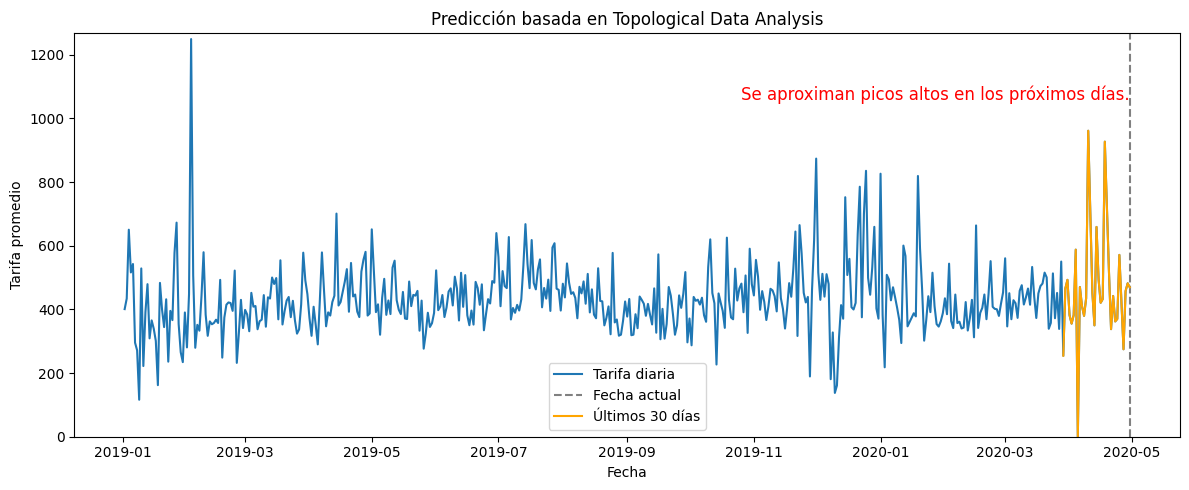

In [65]:
# Crear gráfico
plt.figure(figsize=(12, 5))

# Línea completa de tarifas
plt.plot(serie['Fecha'], serie['Tarifa'], label='Tarifa diaria')

# Línea vertical que marca la fecha actual
plt.axvline(serie['Fecha'].iloc[-1], linestyle='--', color='gray', label='Fecha actual')

# Últimos 30 días coloreados en naranja
plt.plot(serie['Fecha'].iloc[-ventana:], serie['Tarifa'].iloc[-ventana:], color='orange', label='Últimos 30 días')

# Título y etiquetas
plt.title("Predicción basada en Topological Data Analysis")
plt.xlabel("Fecha")
plt.ylabel("Tarifa promedio")
plt.legend()

# Ajuste dinámico de posición del texto dentro del gráfico
max_y = max(serie['Tarifa'].iloc[-ventana:]) * 1.1  # Un poco más alto que el último pico
plt.text(serie['Fecha'].iloc[-1], max_y, mensaje, fontsize=12, color='red', ha='right')

# Ajuste automático de los márgenes
plt.tight_layout()
plt.ylim(0, max_y * 1.2)  # Aumenta el límite superior del eje Y

# Mostrar gráfico
plt.show()
